In [1]:
import re
import pandas as pd

In [2]:
test_pos = pd.read_excel('test_pos.xlsx')
test_pos.rename(columns={test_pos.columns[0]: 'commentaire'}, inplace=True)
test_pos['label'] = 1
for i in range(len(test_pos)):
    file = open ('berta/test/pos/file_pos'+str(i)+'.txt','w', encoding='utf-8')
    file.write(str(test_pos['commentaire'][i]))
    file.close()

In [3]:
test_neg = pd.read_excel('test_neg.xlsx')
test_neg.rename(columns={test_neg.columns[0]: 'commentaire'}, inplace=True)
test_neg['label'] = 1
for i in range(len(test_neg)):
    file = open ('berta/test/neg/file_neg'+str(i)+'.txt','w', encoding='utf-8')
    file.write(str(test_neg['commentaire'][i]))
    file.close()


In [4]:
train_pos = pd.read_excel('train_pos.xlsx')
train_pos.rename(columns={train_pos.columns[0]: 'commentaire'}, inplace=True)
train_pos['label'] = 1
for i in range(len(train_pos)):
    file = open ('berta/train/pos/file_pos'+str(i)+'.txt','w', encoding='utf-8')
    file.write(str(train_pos['commentaire'][i]))
    file.close()

In [5]:
train_neg = pd.read_excel('train_neg.xlsx')
train_neg.rename(columns={train_neg.columns[0]: 'commentaire'}, inplace=True)
train_neg['label'] = 1
for i in range(len(train_neg)):
    file = open ('berta/train/neg/file_neg'+str(i)+'.txt','w', encoding='utf-8')
    file.write(str(train_neg['commentaire'][i]))
    file.close()

In [6]:
!pip install transformers

You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [7]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

In [8]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
import tensorflow as tf
import pandas as pd

In [10]:
train = tf.keras.preprocessing.text_dataset_from_directory(
    'berta/train', batch_size=30000, validation_split=0.2, 
    subset='training', seed=123)
test = tf.keras.preprocessing.text_dataset_from_directory(
    'berta/train', batch_size=30000, validation_split=0.2, 
    subset='validation', seed=123)

Found 13632 files belonging to 3 classes.
Using 10906 files for training.
Found 13632 files belonging to 3 classes.
Using 2726 files for validation.


In [11]:
for i in train.take(1):
    train_feat = i[0].numpy()
    train_lab = i[1].numpy()

train = pd.DataFrame([train_feat, train_lab]).T
train.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
train['DATA_COLUMN'] = train['DATA_COLUMN'].str.decode("utf-8")
train.loc[train['LABEL_COLUMN'] == 1, ['LABEL_COLUMN']] = 0
train.loc[train['LABEL_COLUMN'] == 2, ['LABEL_COLUMN']] = 1
train.head()

,DATA_COLUMN,LABEL_COLUMN
0,رجل الحلقة برافو وليد,1
1,Rajeeeeeeeeeel,1
2,bravo,1
3,M3alma,1
4,Hhhh tha3louba,0


In [12]:
for j in test.take(1):
    test_feat = j[0].numpy()
    test_lab = j[1].numpy()

test = pd.DataFrame([test_feat, test_lab]).T
test.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
test['DATA_COLUMN'] = test['DATA_COLUMN'].str.decode("utf-8")
test.loc[test['LABEL_COLUMN'] == 1, ['LABEL_COLUMN']] = 0
test.loc[test['LABEL_COLUMN'] == 2, ['LABEL_COLUMN']] = 1
test.head()

,DATA_COLUMN,LABEL_COLUMN
0,أمسط منه في تونس ما شفتش وهو ماشي في بالو يضحك,0
1,والله اكبر طحان ريتو في اخياتي زعمة زعم...,0
2,ياسر فييييييييينو,1
3,صوت روعة واصل امنة,1
4,خماج يروجو لانحطاط الاخلاق لافساد مجتمعاتنا ال...,0


In [13]:
InputExample(guid=None,
             text_a = "Hello, world",
             text_b = None,
             label = 1)

InputExample(guid=None, text_a='Hello, world', text_b=None, label=1)

In [14]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
    train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

    validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

    return train_InputExamples, validation_InputExamples

    train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

In [15]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

C:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-05, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

In [17]:
model.fit(train_data, epochs=4, validation_data=validation_data)

Epoch 1/4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
    682/Unknown - 8047s 12s/step - loss: 0.4315 - accuracy: 0.7669WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config o

In [18]:
pred_sentences = ['7yetek ma7leha']
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
    print(pred_sentences[i], ": \n", labels[label[i]])

7yetek ma7leha : 
 Positive


In [19]:
pred_sentences = ['orange a7sen operateur fi tounes']
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
    print(pred_sentences[i], ": \n", labels[label[i]])

orange a7sen operateur fi tounes : 
 Positive


In [20]:
dataset_name = 'satisfaction'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))
model.save(saved_model_path, include_optimizer=True)

INFO:tensorflow:Assets written to: ./satisfaction_bert\assets


INFO:tensorflow:Assets written to: ./satisfaction_bert\assets


In [21]:
dataset_name = 'satisfaction'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))
reloaded_model = tf.saved_model.load(saved_model_path )

In [22]:
scrapped_comments = pd.read_csv('scrapped_comments.csv')

In [23]:
scrapped_comments['label'] = 0
scrapped_comments

,commentaire,label
0,يهديكم اكهو يزي منها,0
1,eli la7edhtou meli 3malt portabilité o badalt ...,0
2,benesba lel adsl ahsen wehed mel les 3 opérate...,0
3,Télécom se sont des voleurs par expérience... ...,0
4,Service Zbeeeeeeeeeeeeeeela,0
5,rodou belkom temchiw el orange fi central park...,0
6,ba3d 2 semaines 3waj ma3adech compréhensible y...,0
7,Allez vous debrouiller chez Orange mais cela n...,0
8,Hhhhhhhhhhh ken kedhbb w barra ken sTiii777 ma...,0
9,Kifeh najem nechri,0


In [24]:
for i in range(len(scrapped_comments)):
    pred_sentences = str(scrapped_comments.at[i,'commentaire'])
    tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
    tf_outputs = model(tf_batch)
    tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
    labels = [0,1]
    label = tf.argmax(tf_predictions, axis=1)
    label = label.numpy()
    scrapped_comments.at[i,'label'] = labels[label[0]]

In [25]:
scrapped_comments

,commentaire,label
0,يهديكم اكهو يزي منها,0
1,eli la7edhtou meli 3malt portabilité o badalt ...,0
2,benesba lel adsl ahsen wehed mel les 3 opérate...,0
3,Télécom se sont des voleurs par expérience... ...,1
4,Service Zbeeeeeeeeeeeeeeela,1
5,rodou belkom temchiw el orange fi central park...,0
6,ba3d 2 semaines 3waj ma3adech compréhensible y...,0
7,Allez vous debrouiller chez Orange mais cela n...,1
8,Hhhhhhhhhhh ken kedhbb w barra ken sTiii777 ma...,0
9,Kifeh najem nechri,0


In [26]:
from pandas import ExcelWriter

writer = ExcelWriter('scrapped_comments.xlsx')
scrapped_comments.to_excel(writer)
writer.save()

In [27]:
from sklearn.metrics import confusion_matrix, classification_report,precision_score,accuracy_score,f1_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [28]:
trueSTR = test.copy()
trueSTR.loc[test['LABEL_COLUMN'] == 0, 'LABEL_COLUMN'] = 'negative'
trueSTR.loc[test['LABEL_COLUMN'] == 1, 'LABEL_COLUMN'] = 'positive'

In [29]:
predictedSTR =  []
for i in range(len(test)):
    pred_sentences = str(test.at[i,'DATA_COLUMN'])
    tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
    tf_outputs = model(tf_batch)
    tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
    labels = [0,1]
    label = tf.argmax(tf_predictions, axis=1)
    label = label.numpy()
    if labels[label[0]] == 0:
        predictedSTR.append('negative')
    else:
        predictedSTR.append('positive')
    
    

In [30]:
predictedINT =  []
for i in range(len(test)):
    pred_sentences = str(test.at[i,'DATA_COLUMN'])
    tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
    tf_outputs = model(tf_batch)
    tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
    labels = [0,1]
    label = tf.argmax(tf_predictions, axis=1)
    label = label.numpy()
    predictedINT.append(labels[label[0]]) 

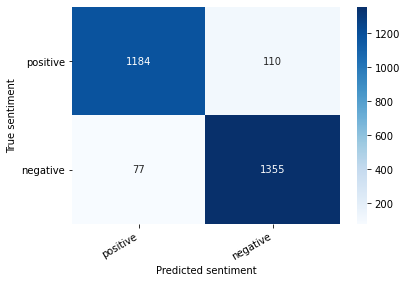

In [31]:
class_names = ["positive", "negative"]
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');
cm = confusion_matrix(trueSTR['LABEL_COLUMN'], predictedSTR)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [32]:
print(classification_report(trueSTR['LABEL_COLUMN'], predictedSTR, target_names = class_names))

              precision    recall  f1-score   support

    positive       0.94      0.91      0.93      1294
    negative       0.92      0.95      0.94      1432

    accuracy                           0.93      2726
   macro avg       0.93      0.93      0.93      2726
weighted avg       0.93      0.93      0.93      2726

